In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from nn_trainer import ae_train

from util.custom_loss.custom_loss import mse_loss, sparsity_loss, dirichlet_loss
from util.ImageFolderWithPaths import ImageFolderWithPaths
from util.random_patient import random_split

In [2]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

1


(16790978560, 17059545088)

In [3]:
BATCH_SIZE = 500

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'

SPLIT = [55767, 6971, 6971]

tensor_transform = transforms.ToTensor()
#horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) #+ datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
 #                                                                                                                     tensor_transform,
 #                                                                                                                     horizontal_flip
 #                                                                                                                  ]))


train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [4]:
encoded_dim = 2048
rand_mat_dim = 1024 # try identity matrix

In [5]:
AE = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=True).to(device)

In [6]:
AE

AE_CNN(
  (softmax): Softmax(dim=1)
  (encoder): Encoder(
    (nn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): AvgPool2d(kernel_size=2, stride=2, padding=1)
      (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU()
      (14

In [7]:
AE.rand_mat

tensor([[ 0.0321, -0.0480, -0.0306,  ..., -0.0236,  0.0015, -0.0268],
        [-0.0121, -0.0261, -0.0011,  ...,  0.0142,  0.0199, -0.0087],
        [ 0.0265, -0.0053,  0.0119,  ..., -0.0111,  0.0006,  0.0183],
        ...,
        [ 0.0058,  0.0226, -0.0007,  ...,  0.0281,  0.0419,  0.0036],
        [ 0.0243,  0.0311, -0.0164,  ...,  0.0207,  0.0607,  0.0357],
        [-0.0277, -0.0577,  0.0178,  ..., -0.0368,  0.0146,  0.0571]],
       device='cuda:0')

In [8]:
with open('progress.txt', 'w') as file:
    file.write(f"{AE=}\n\nTraining:\n")

In [9]:
EPOCHS = 25 # about 3.33/hr
loss_weights = [1, 0, 0] # chagne l2 to 1, 0.5, 0.1
early_stop_depth = 20
verbose = 1

LR = [0.001]
WEIGHT_DECAY = [0.005]

In [10]:
torch.autograd.set_detect_anomaly(True)
min_loss = None
d = {}
for lr in LR:
    AE = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=False).to(device)
    AE.rand_mat = torch.eye(rand_mat_dim)
    for wd in WEIGHT_DECAY:  
        with open('progress.txt', 'a') as file:
            file.write(f"{lr=} | {wd=}\n")
        optimizer = torch.optim.Adam(AE.parameters(), lr = lr, weight_decay = wd)
        outputs, loss_arr = ae_train(AE, train_loader, optimizer, EPOCHS, loss_weights, early_stop_depth, verbose)
        if loss_arr: # ignore nan
            d[str(lr) + "|"+str(wd)] = loss_arr[-1]
            if not min_loss or min_loss > loss_arr[-1]:
                min_loss = loss_arr[-1]
                torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
                with open('progress.txt', 'a') as file:
                    file.write(f"New AE: {min_loss=}\n")
                print(f"New AE: {min_loss=}\n")

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.33 GiB. GPU 

In [ ]:
#torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
torch.save(AE.rand_mat, f'./models/ae_model_rand_mat.pth')
torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')

with open('progress.txt', 'a') as file:
    file.write(f"Saved\n\n")
print("done")

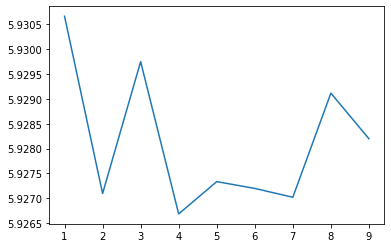

In [12]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.show()

In [5]:
print(torch.cuda.mem_get_info())
torch.cuda.empty_cache()

(16734355456, 17059545088)


In [6]:
torch.set_default_device('cuda')

MAIN_PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'

SPLIT = [55767, 6971, 6971]

tensor_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(MAIN_PATH, 
                               transform = tensor_transform) #loads the images

_, val_set, _ = torch.utils.data.random_split(dataset,
                                                   SPLIT,
                                                   generator=torch.Generator(device='cuda'))

val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                    batch_size = 1,
                                    shuffle = True,
                                    generator=torch.Generator('cuda'))

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=False).to(device)
model.load_state_dict(torch.load('./models/ae_model_gs-Copy1.pth'))
model.rand_mat = torch.load('./models/ae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [16]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
count = 0

torch.set_default_device('cuda')

for (inp, _) in val_loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup = model(inp)
        encoded_imgs = torch.mv(rand_mat, model.softmax(encoder(inp))[0])
        encoded_imgs_arr.append(encoded_imgs)
        
#         decoded_imgs = decoder(encoded_imgs)
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()

        
        
        # decoded_imgs_arr.append((inp, decoded_imgs))
        
        if count % 100 == 0:
            auto_encoder_output.append((inp, model(inp)))
        count += 1



In [17]:
mse_running_total/len(val_loader)

0.014062333167371613

In [18]:
encoded_imgs_arr[0]

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0')

In [19]:
encoded_imgs_arr[1]

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0')

In [20]:
mse_running_total = 0
for (img, _) in val_loader:
    model.eval()
    with torch.no_grad():

        inp = img.to(device)
        decoded = model(inp)
        mse_running_total += np.square(inp.cpu().numpy() - decoded.cpu().numpy()).mean()
        break

torch.Size([3, 299, 299])
0.02092183195054531


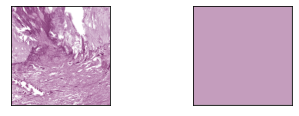

In [24]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = decoded.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

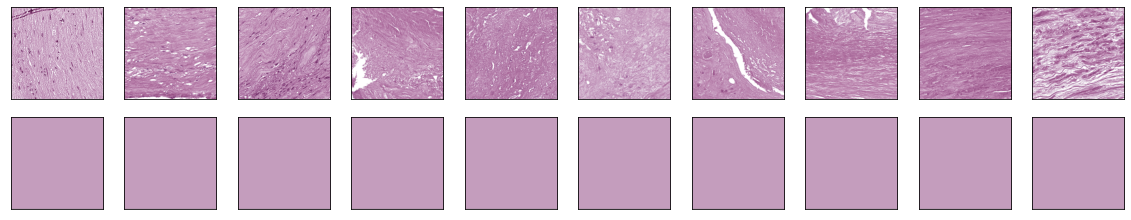

In [25]:
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k+10][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k+10][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

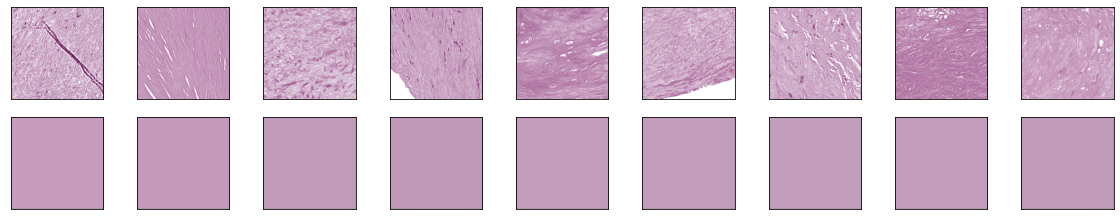

In [26]:
amt = len(outputs)
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = outputs[k][0][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = outputs[k][1][0].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [25]:
recon1, recon2 = auto_encoder_output[0][1], auto_encoder_output[1][1]

In [26]:
recon1, recon2 = auto_encoder_output[0][1], auto_encoder_output[1][1]

In [36]:
for i in range(len(auto_encoder_output)-1):
    recon1, recon2 = auto_encoder_output[i][1], auto_encoder_output[i+1][1]
    print(torch.sum(recon1 - recon2))

tensor(3.9220e-05, device='cuda:0')
tensor(-1.2696e-05, device='cuda:0')
tensor(5.1677e-05, device='cuda:0')
tensor(3.1352e-05, device='cuda:0')
tensor(-4.2796e-05, device='cuda:0')
tensor(6.6161e-06, device='cuda:0')
tensor(-4.1127e-06, device='cuda:0')
tensor(-3.3140e-05, device='cuda:0')
tensor(-1.6570e-05, device='cuda:0')
tensor(2.6941e-05, device='cuda:0')
tensor(1.2875e-05, device='cuda:0')
tensor(2.3365e-05, device='cuda:0')
tensor(-8.8692e-05, device='cuda:0')
tensor(7.0691e-05, device='cuda:0')
tensor(-2.4438e-06, device='cuda:0')
tensor(4.6551e-05, device='cuda:0')
tensor(-5.9068e-05, device='cuda:0')
tensor(-1.5259e-05, device='cuda:0')
tensor(1.2279e-05, device='cuda:0')
tensor(3.0398e-06, device='cuda:0')
tensor(-9.9182e-05, device='cuda:0')
tensor(3.3259e-05, device='cuda:0')
tensor(7.6592e-05, device='cuda:0')
tensor(-7.9274e-06, device='cuda:0')
tensor(-3.2246e-05, device='cuda:0')
tensor(3.6359e-06, device='cuda:0')
tensor(6.7949e-05, device='cuda:0')
tensor(-7.3254e-